### D214 - Capstone - PA2

### Background Info:

**-- PA 1 is complete.**  
**-- PA 2: Prep data for ANOVA analysis and to export to Tableau.**

**A1 _Question: Is communication from a doctor more statistically significant to a patients overall hospital rating than a nurse?_**

--- 
### Import Libraries
---

In [1]:
# Standard libraries

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels as stats
from pandas import DataFrame
from scipy.stats import kurtosis, skew
from matplotlib.ticker import StrMethodFormatter

# get ANOVA table
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

## Handle Warnings
import warnings
warnings.filterwarnings('ignore')
## Warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
#
## Timer for debugging
#%time
#%timeit

In [2]:
from platform import python_version
print('The python version used is: %s' % python_version())

The python version used is: 3.9.13


** Load Data

In [3]:
# load data file
df = pd.read_csv('HCAHPS-Hospital.csv')
# quick test the data is present and see the shape
df.head(5)  # DtypeWarning: Columns (12,14,17,19) have mixed types. Specify dtype option on import or set low_memory=False.

,Facility ID,Facility Name,Address,City,State,ZIP Code,County Name,Phone Number,HCAHPS Measure ID,HCAHPS Question,...,Patient Survey Star Rating Footnote,HCAHPS Answer Percent,HCAHPS Answer Percent Footnote,HCAHPS Linear Mean Value,Number of Completed Surveys,Number of Completed Surveys Footnote,Survey Response Rate Percent,Survey Response Rate Percent Footnote,Start Date,End Date
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_A_P,"Patients who reported that their nurses ""Alway...",...,NaN,77,NaN,Not Applicable,501,NaN,19,NaN,10/01/2020,09/30/2021
1,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_SN_P,"Patients who reported that their nurses ""Somet...",...,NaN,7,NaN,Not Applicable,501,NaN,19,NaN,10/01/2020,09/30/2021
2,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_U_P,"Patients who reported that their nurses ""Usual...",...,NaN,16,NaN,Not Applicable,501,NaN,19,NaN,10/01/2020,09/30/2021
3,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_LINEAR_SCORE,Nurse communication - linear mean score,...,NaN,Not Applicable,NaN,90,501,NaN,19,NaN,10/01/2020,09/30/2021
4,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,H_COMP_1_STAR_RATING,Nurse communication - star rating,...,NaN,Not Applicable,NaN,Not Applicable,501,NaN,19,NaN,10/01/2020,09/30/2021


---
### Data Cleaning & Exploratory Data Analysis
---

In [4]:
df.columns

Index(['Facility ID', 'Facility Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'HCAHPS Measure ID', 'HCAHPS Question',
       'HCAHPS Answer Description', 'Patient Survey Star Rating',
       'Patient Survey Star Rating Footnote', 'HCAHPS Answer Percent',
       'HCAHPS Answer Percent Footnote', 'HCAHPS Linear Mean Value',
       'Number of Completed Surveys', 'Number of Completed Surveys Footnote',
       'Survey Response Rate Percent', 'Survey Response Rate Percent Footnote',
       'Start Date', 'End Date'],
      dtype='object')

In [5]:
# Remove Unecessary Data Series
df_clean = df[['HCAHPS Answer Description', 'Patient Survey Star Rating']]

# Rename Columns
df_clean = df_clean.rename(columns={'HCAHPS Answer Description':'Questions',
                                     'Patient Survey Star Rating':'Ratings'})

In [6]:
# DtypeWarning: Columns (12,14,17,19) have mixed types. Specify dtype option on import or set low_memory=False.

df_clean = df_clean.drop(df_clean[df_clean['Ratings'].isin(['Not Applicable', 'Not Available'])].index)  # Index --> of row
df_clean['Ratings'] = df_clean['Ratings'].astype(int)

df_clean.sample(20)

,Questions,Ratings
60224,Discharge information - star rating,5
16793,Discharge information - star rating,4
72249,Quietness - star rating,2
281461,Communication about medicines - star rating,3
367289,Staff responsiveness - star rating,3
197055,Quietness - star rating,5
95078,Staff responsiveness - star rating,1
87473,Discharge information - star rating,4
295924,Recommend hospital - star rating,4
220956,Quietness - star rating,3


In [7]:
# Verify Ratins Series is of type integer
df_clean.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36520 entries, 4 to 449747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  36520 non-null  object
 1   Ratings    36520 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 855.9+ KB


In [8]:
print("*******"*5)
print("* DataFrame Shape: ", df_clean.shape)
print("*******"*5)
df_clean.describe(include='all')

***********************************
* DataFrame Shape:  (36520, 2)
***********************************


,Questions,Ratings
count,36520,36520.000000
unique,11,NaN
top,Nurse communication - star rating,NaN
freq,3320,NaN
mean,NaN,3.158050
std,NaN,1.008707
min,NaN,1.000000
25%,NaN,2.000000
50%,NaN,3.000000
75%,NaN,4.000000


In [9]:
df_clean.head(-5)

,Questions,Ratings
4,Nurse communication - star rating,3
18,Doctor communication - star rating,3
32,Staff responsiveness - star rating,2
43,Communication about medicines - star rating,3
53,Discharge information - star rating,4
...,...,...
449673,Doctor communication - star rating,4
449687,Staff responsiveness - star rating,3
449698,Communication about medicines - star rating,3
449708,Discharge information - star rating,4


In [10]:
pd.unique(df_clean['Questions'])

array(['Nurse communication - star rating',
       'Doctor communication - star rating',
       'Staff responsiveness - star rating',
       'Communication about medicines - star rating',
       'Discharge information - star rating',
       'Care transition - star rating', 'Cleanliness - star rating',
       'Quietness - star rating', 'Overall hospital rating - star rating',
       'Recommend hospital - star rating', 'Summary star rating'],
      dtype=object)

### Check for Missing or Null Values

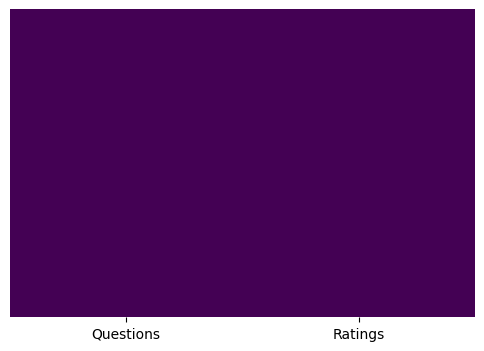

In [11]:
# Mapping to view missing data...none present.
fig, ax = plt.subplots(figsize=(6,4))         # Sample figsize in inches
sns.heatmap(df_clean.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [12]:
# Drop any null columns
df_clean = df_clean.dropna()

print("*******"*5)
print("* Any Rows Missing: ",df_clean.isnull().all(axis=1).any())
print("*******"*5)
print("Any Null Values:\n", df_clean.isnull().any())

***********************************
* Any Rows Missing:  False
***********************************
Any Null Values:
 Questions    False
Ratings      False
dtype: bool


#### Explore Data

In [13]:
# Sample DataFrame Fields
df_clean.head()

,Questions,Ratings
4,Nurse communication - star rating,3
18,Doctor communication - star rating,3
32,Staff responsiveness - star rating,2
43,Communication about medicines - star rating,3
53,Discharge information - star rating,4


In [14]:
# Understand Columns, Shape and Types
print("*************"*5)
print("* DF Columns: ",df_clean.columns)
print("*************"*5)
df_clean.info()

*****************************************************************
* DF Columns:  Index(['Questions', 'Ratings'], dtype='object')
*****************************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36520 entries, 4 to 449747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  36520 non-null  object
 1   Ratings    36520 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 855.9+ KB


In [15]:
# Export Cleaned data
pd.DataFrame(df_clean).to_csv('df_clean.csv')

In [16]:
# Using lambda
df_clean = df_clean[df_clean["Questions"].isin(['Nurse communication - star rating',
                                                'Doctor communication - star rating',
                                                'Overall hospital rating - star rating'])]
df_clean.dropna()
df_clean.sample(20)

,Questions,Ratings
113267,Overall hospital rating - star rating,3
312019,Nurse communication - star rating,3
41750,Overall hospital rating - star rating,2
192224,Overall hospital rating - star rating,4
365,Overall hospital rating - star rating,4
190296,Doctor communication - star rating,3
164056,Nurse communication - star rating,4
207766,Nurse communication - star rating,4
444930,Doctor communication - star rating,4
281529,Doctor communication - star rating,3


In [17]:
print('********'*5)
print('*** Describe Data ***')
print('********'*5)
print('* Median: ',df_clean.median())
print('********'*5)

print('Mode: ' + str(df_clean['Questions'].value_counts(ascending=True).loc[lambda x : x>1].to_frame()) + 
      '\n\n' + str(df_clean['Ratings'].value_counts(ascending=True).loc[lambda x : x>1].to_frame()))

****************************************
*** Describe Data ***
****************************************
* Median:  Ratings    3.0
dtype: float64
****************************************
Mode:                                        Questions
Nurse communication - star rating           3320
Doctor communication - star rating          3320
Overall hospital rating - star rating       3320

   Ratings
1      374
5      995
2     1903
4     3189
3     3499


In [18]:
df_grouped = df_clean.groupby(['Questions'],as_index=False).mean()
print(df_grouped)

                               Questions   Ratings
0     Doctor communication - star rating  3.238253
1      Nurse communication - star rating  3.259940
2  Overall hospital rating - star rating  3.263253


---
### Visualize Data
---

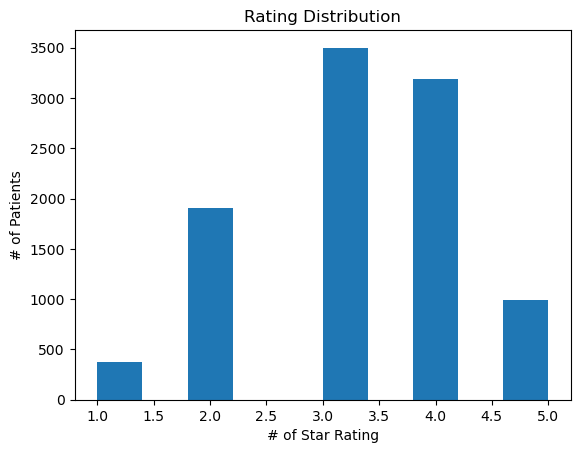

In [19]:
# Ratings Distribution 
df_clean['Ratings'].plot.hist();

plt.xlabel('# of Star Rating')
plt.ylabel('# of Patients')
plt.title('Rating Distribution');

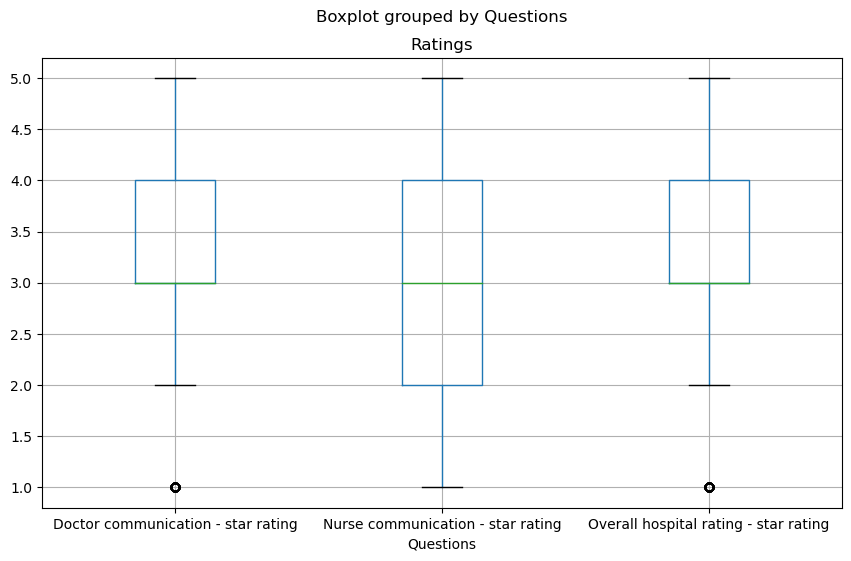

In [20]:
# Create Boxplot
df_clean.boxplot('Ratings', by='Questions', figsize=(10, 6))

control = df_clean['Ratings'][df_clean['Questions'] == 'Overall hospital rating - star rating']

grps = pd.unique(df_clean['Questions'].values)
d_data = {grp:df_clean['Ratings'][df_clean['Questions'] == grp] for grp in grps}

k = len(pd.unique(df_clean['Questions']))  # number of conditions
N = len(df_clean.values)  # conditions times participants
n = df_clean.groupby('Questions').size()[0] #Participants in each condition

---
### One-Way ANOVA
---

In [21]:
# Set up ANOVA Model
mod = ols('Ratings ~ C(Questions)', # Note the Catigorical Data C()
                data=df_clean).fit() 

# Carry out the ANOVA                
aov_table = sm.stats.anova_lm(mod)
print(aov_table)

                  df       sum_sq   mean_sq         F    PR(>F)
C(Questions)     2.0     1.224297  0.612149  0.614114  0.541141
Residual      9957.0  9925.130723  0.996799       NaN       NaN


In [22]:
print(mod.summary()) # Print More Details

                            OLS Regression Results                            
Dep. Variable:                Ratings   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6141
Date:                Thu, 08 Sep 2022   Prob (F-statistic):              0.541
Time:                        09:57:52   Log-Likelihood:                -14115.
No. Observations:                9960   AIC:                         2.824e+04
Df Residuals:                    9957   BIC:                         2.826e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

## End 